In [1]:
import pandas as pd
import numpy as np
import itertools
import scipy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime

from sklearn.decomposition import PCA
import plotly.express as px

from dateutil import parser
from datetime import date

from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from flaml import AutoML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from catboost import CatBoostClassifier
import scikitplot as skplt
import missingno as msno
from sklearn.feature_selection import RFE

In [2]:
rawData = pd.read_csv("./marketing_data.csv")
target = rawData["Response"]
data = rawData.drop(columns=["Response"])

data.rename(columns={' Income ':'Income'}, inplace=True)
data['Income'] = data['Income'].str.replace(',', '').str.replace('$', '').astype(float)
data.info()

plt.rcParams['figure.figsize'] = [12, 8]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

<ipython-input-2-df33831ea70b>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['Income'] = data['Income'].str.replace(',', '').str.replace('$', '').astype(float)


# Data clean up

### Convert columns to type category if applicable

In [3]:
data["Education"] = data["Education"].astype("category")
data["Marital_Status"] = data["Marital_Status"].astype("category")
data["Kidhome"] = data["Kidhome"].astype("category")
data["Teenhome"] = data["Teenhome"].astype("category")
data["Complain"] = data["Complain"].astype("category")
data["Country"] = data["Country"].astype("category")

<AxesSubplot:>

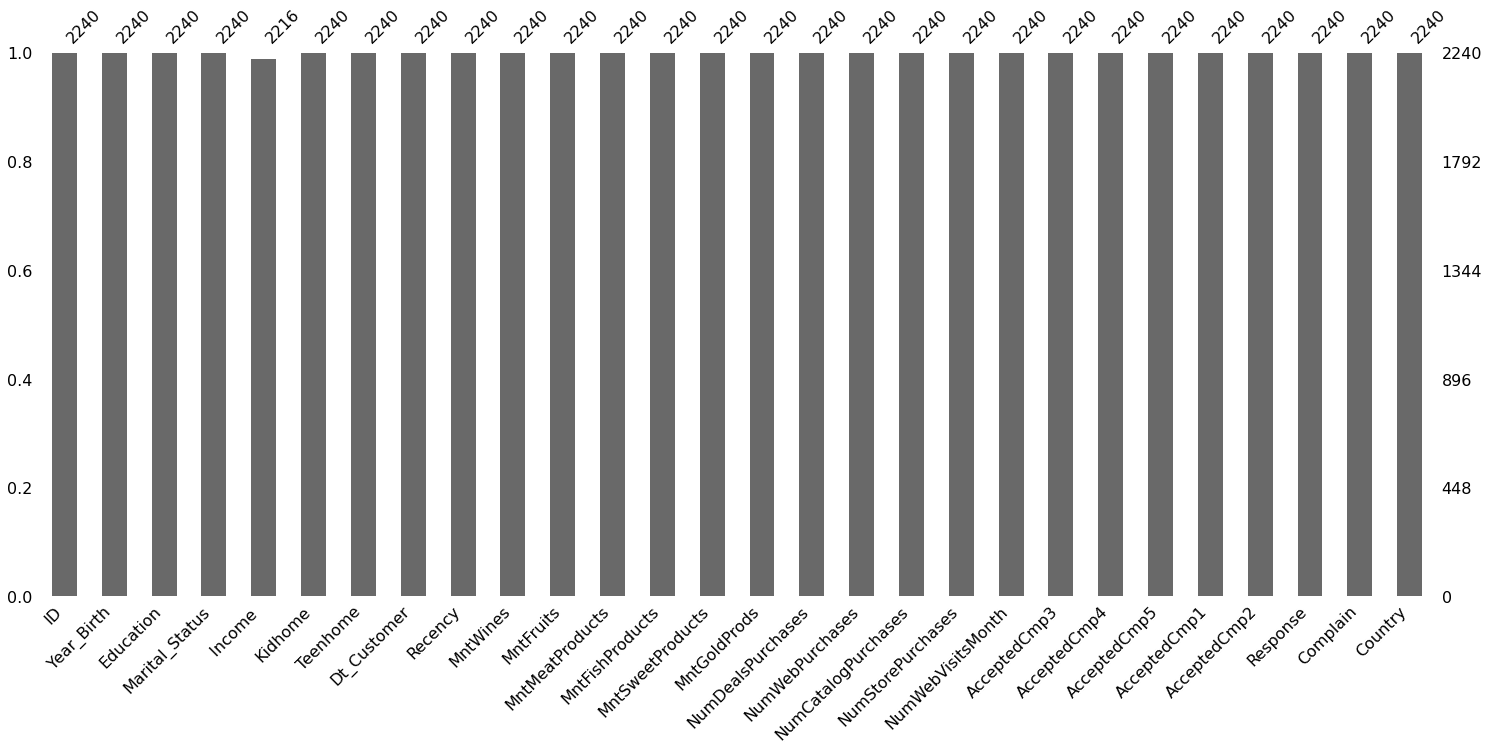

In [4]:
msno.bar(rawData)

### impute missing cells in Income column

In [5]:
data["Income"].mean()
data['Income'] = np.where(data["Income"].isnull(), data["Income"].mean(), data["Income"])

check for null cells

In [6]:
data.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Country                0
dtype: int64

# Cluster analysis

### normalize the data

In [7]:
clusterData = data

numericData = clusterData.select_dtypes(include=np.number)
numericData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Income               2240 non-null   float64
 3   Recency              2240 non-null   int64  
 4   MntWines             2240 non-null   int64  
 5   MntFruits            2240 non-null   int64  
 6   MntMeatProducts      2240 non-null   int64  
 7   MntFishProducts      2240 non-null   int64  
 8   MntSweetProducts     2240 non-null   int64  
 9   MntGoldProds         2240 non-null   int64  
 10  NumDealsPurchases    2240 non-null   int64  
 11  NumWebPurchases      2240 non-null   int64  
 12  NumCatalogPurchases  2240 non-null   int64  
 13  NumStorePurchases    2240 non-null   int64  
 14  NumWebVisitsMonth    2240 non-null   int64  
 15  AcceptedCmp3         2240 non-null   i

In [8]:
columnName = list(numericData.columns)
columnName.remove("ID")
columnName.remove("AcceptedCmp1")
columnName.remove("AcceptedCmp2")
columnName.remove("AcceptedCmp3")
columnName.remove("AcceptedCmp4")
columnName.remove("AcceptedCmp5")
columnName.remove("Year_Birth")

In [9]:
scaler = StandardScaler()
clusterData[columnName] = scaler.fit_transform(clusterData[columnName])


In [10]:
clusterTarget = rawData["Response"]

encoder = ce.OneHotEncoder()
encoder.fit(clusterData, clusterTarget)
clusterClean = encoder.transform(clusterData)

C:\Users\tommy\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [11]:
clusterClean.head(10)

,ID,Year_Birth,Education_1,Education_2,Education_3,Education_4,Education_5,Marital_Status_1,Marital_Status_2,Marital_Status_3,...,Complain_1,Complain_2,Country_1,Country_2,Country_3,Country_4,Country_5,Country_6,Country_7,Country_8
0,1826,1970,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1,1,1961,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
2,10476,1958,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
3,1386,1967,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,5371,1989,1,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
5,7348,1958,0,1,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
6,4073,1954,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
7,1991,1967,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
8,4047,1954,0,1,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
9,9477,1954,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


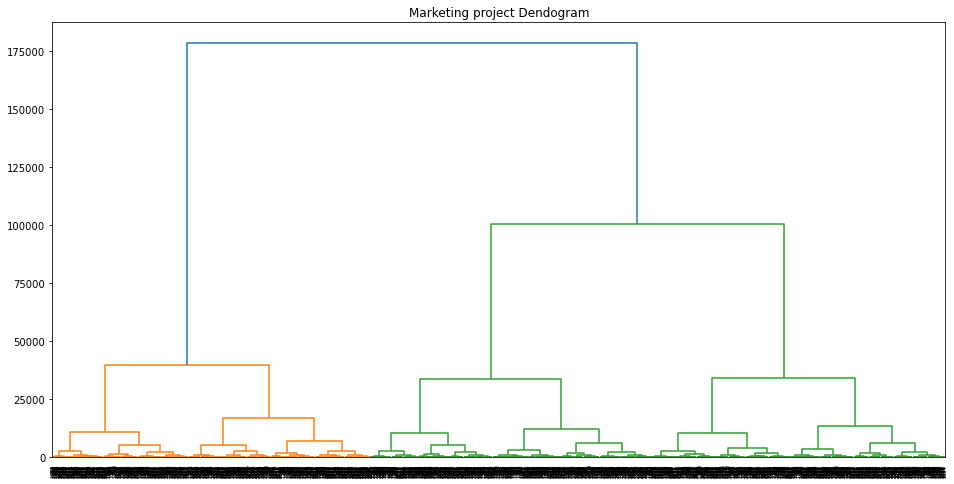

In [12]:
aggl = scipy.cluster.hierarchy.linkage(clusterClean, method='ward', metric='euclidean')

# Plot the dendogram
plt.figure(figsize=(16, 8));
plt.grid(False)
plt.title("Marketing project Dendogram");  
dend = scipy.cluster.hierarchy.dendrogram(aggl); 

In [13]:
hierar = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierar.fit(clusterClean)

AgglomerativeClustering(n_clusters=3)

In [14]:
clusterOutput = data
clusterOutput["cluster"] = hierar.labels_
clusterOutput.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Country,cluster
0,1826,1970,Graduation,Divorced,1.301833,0,0,6/16/14,-1.696001,-0.341540,...,0.064556,-1.779198,0,0,0,0,0,0,SP,0
1,1,1961,Graduation,Single,0.193501,0,0,6/15/14,-1.696001,0.475643,...,0.372226,-0.130463,0,0,0,0,1,0,CA,0
2,10476,1958,Graduation,Married,0.600017,0,1,5/13/14,-1.696001,-0.504976,...,-0.243114,-1.367014,0,0,0,0,0,0,US,2
3,1386,1967,Graduation,Together,-0.789912,1,1,2005-11-14,-1.696001,-0.873451,...,-1.166125,0.693904,0,0,0,0,0,0,AUS,0
4,5371,1989,Graduation,Single,-1.229346,1,0,2004-08-14,-1.696001,-0.885337,...,-1.166125,0.693904,1,0,0,0,0,0,SP,1


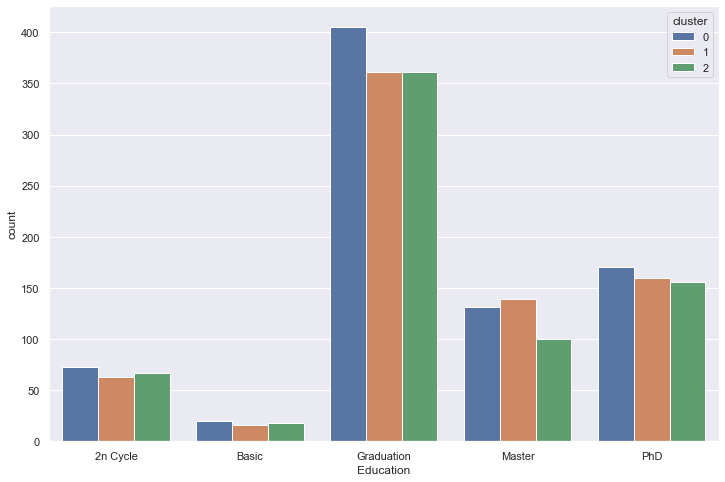

In [15]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Education", hue="cluster" , data=clusterOutput)

C:\Users\tommy\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'cluster 2')

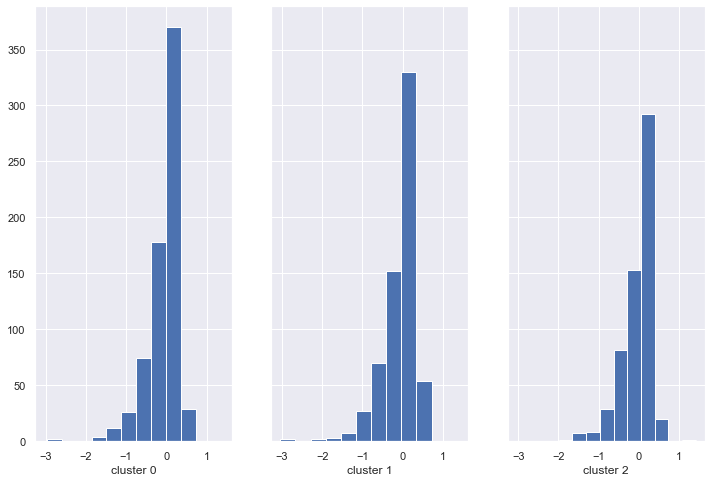

In [22]:
incomeData = clusterOutput[["Income","cluster"]]
cluster0 = incomeData[incomeData["cluster"]==0]
cluster1 = incomeData[incomeData["cluster"]==1]
cluster2 = incomeData[incomeData["cluster"]==2]
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

axs[0].hist(np.log10(cluster0["Income"] + 1))
axs[0].set_xlabel('cluster 0')
axs[1].hist(np.log10(cluster1["Income"] + 1))
axs[1].set_xlabel('cluster 1')
axs[2].hist(np.log10(cluster2["Income"] + 1))
axs[2].set_xlabel('cluster 2')

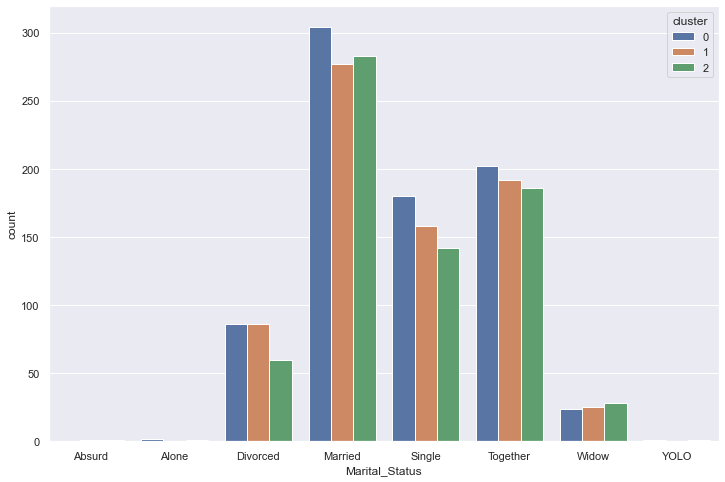

In [23]:
ax = sns.countplot(x="Marital_Status", hue="cluster", data=clusterOutput)

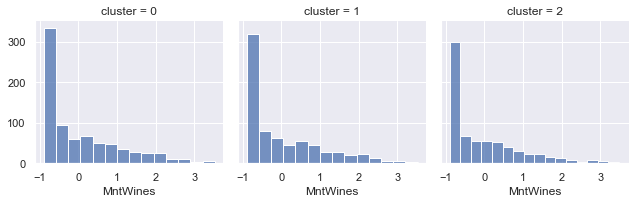

In [24]:
g = sns.FacetGrid(clusterOutput, col="cluster")
g.map(sns.histplot, "MntWines")

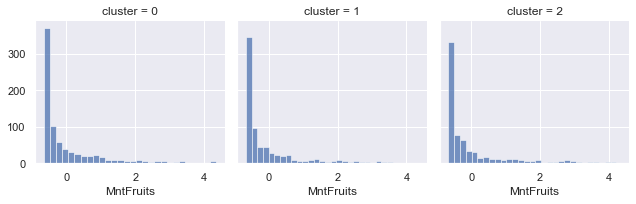

In [25]:
g = sns.FacetGrid(clusterOutput, col="cluster")
g.map(sns.histplot, "MntFruits")

C:\Users\tommy\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


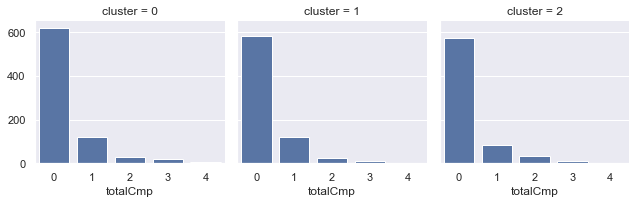

In [27]:
clusterOutput["totalCmp"] = clusterOutput["AcceptedCmp1"] + clusterOutput["AcceptedCmp2"] + clusterOutput["AcceptedCmp3"] + clusterOutput["AcceptedCmp4"] + clusterOutput["AcceptedCmp5"]
g = sns.FacetGrid(clusterOutput, col="cluster")
g.map(sns.countplot, "totalCmp")


# Feature Engineering / Transformation

### Convert DT_Customer from string to number of year loyality

In [91]:
convertedDate = pd.to_datetime(data["Dt_Customer"], infer_datetime_format=True)
mostRecentDate = convertedDate.max()
daysDiff = mostRecentDate - convertedDate
daysDiff = daysDiff.dt.days
data["yearsLoyality"] = daysDiff // 365
data = data.drop(columns=["Dt_Customer"])

### Convert Year_Birth to age

In [92]:
data["age"] = mostRecentDate.year - data["Year_Birth"]
data = data.drop(columns=["Year_Birth"])

### total campaign accepted

In [93]:
data["totalCmp"] = data["AcceptedCmp1"] +data["AcceptedCmp2"] +data["AcceptedCmp3"] +data["AcceptedCmp4"] + data["AcceptedCmp5"]

### log transformation for numeric features

In [94]:
data["log_Income"] = np.log10(data["Income"] + 1)
data["log_MntWines"] = np.log(data["MntWines"] + 1)
data["log_MntFruits"] = np.log(data["MntFruits"] + 1)
data["log_MntMeatProducts"] = np.log(data["MntMeatProducts"] + 1)
data["log_MntFishProducts"] = np.log(data["MntFishProducts"] + 1)
data["log_MntSweetProducts"] = np.log(data["MntSweetProducts"] + 1)
data["log_MntGoldProds"] = np.log(data["MntGoldProds"] + 1)

In [ ]:
## data is skewed to the left
sns.histplot(data=data, x="Income")

In [96]:
data = data.drop(columns=["Income", "MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"])

<AxesSubplot:xlabel='log_Income', ylabel='Count'>

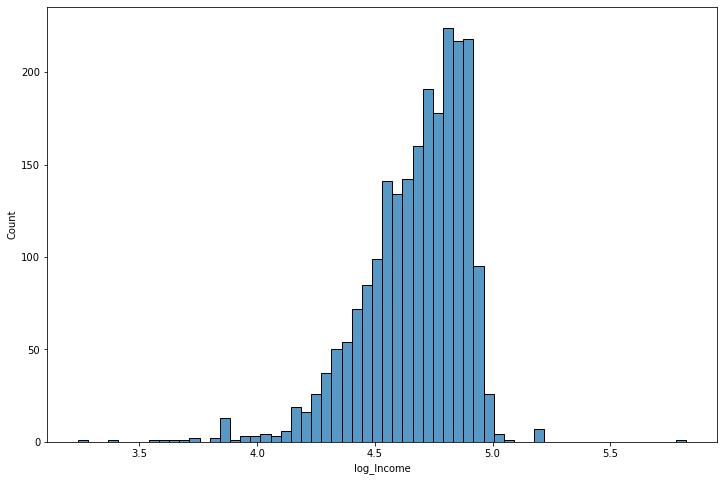

In [97]:
## data skewness is resolve with log transformation

sns.histplot(data=data, x="log_Income")

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID                    2240 non-null   int64   
 1   Education             2240 non-null   category
 2   Marital_Status        2240 non-null   category
 3   Kidhome               2240 non-null   category
 4   Teenhome              2240 non-null   category
 5   Recency               2240 non-null   int64   
 6   NumDealsPurchases     2240 non-null   int64   
 7   NumWebPurchases       2240 non-null   int64   
 8   NumCatalogPurchases   2240 non-null   int64   
 9   NumStorePurchases     2240 non-null   int64   
 10  NumWebVisitsMonth     2240 non-null   int64   
 11  AcceptedCmp3          2240 non-null   int64   
 12  AcceptedCmp4          2240 non-null   int64   
 13  AcceptedCmp5          2240 non-null   int64   
 14  AcceptedCmp1          2240 non-null   int64   
 15  Acce

# Modelling

### Split the data

In [99]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

### encoding

In [100]:
encoder = ce.TargetEncoder()
training_dataset = encoder.fit_transform(X_train, y_train)

C:\Users\tommy\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [101]:
clf=RandomForestClassifier(class_weight = "balanced", random_state=0)
clf.fit(training_dataset,y_train)

RandomForestClassifier(class_weight='balanced', random_state=0)

In [102]:
selector = RFE(clf, n_features_to_select=15, step=1)
selector = selector.fit(training_dataset, y_train)

In [103]:
encoder = ce.TargetEncoder()
testing_dataset = encoder.fit_transform(X_test, y_test)

y_pred_dt = clf.predict(testing_dataset)

C:\Users\tommy\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [104]:
y_pred_dt = selector.predict(testing_dataset)

In [105]:
class_names = [str(x) for x in clf.classes_]
print(classification_report(y_test, y_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94       585
           1       0.63      0.22      0.32        87

    accuracy                           0.88       672
   macro avg       0.76      0.60      0.63       672
weighted avg       0.86      0.88      0.86       672



In [106]:
print(confusion_matrix(y_test, y_pred_dt))

[[574  11]
 [ 68  19]]


## Trying out AutoML

In [112]:
automl = AutoML()
automl.fit(training_dataset, y_train, task="classification")

[flaml.automl: 08-09 23:57:39] {912} INFO - Evaluation method: cv
[flaml.automl: 08-09 23:57:39] {606} INFO - Using StratifiedKFold
[flaml.automl: 08-09 23:57:39] {933} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 08-09 23:57:39] {952} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl: 08-09 23:57:39] {1018} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-09 23:57:39] {1173} INFO -  at 0.1s,	best lgbm's error=0.2335,	best lgbm's error=0.2335
[flaml.automl: 08-09 23:57:39] {1018} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-09 23:57:39] {1173} INFO -  at 0.2s,	best lgbm's error=0.2296,	best lgbm's error=0.2296
[flaml.automl: 08-09 23:57:39] {1018} INFO - iteration 2, current learner lgbm
[flaml.automl: 08-09 23:57:39] {1173} INFO -  at 0.3s,	best lgbm's error=0.2296,	best lgbm's error=0.2296
[flaml.automl: 08-09 23:57:39] {1018} INFO - iteration 3, current learner lgbm
[flaml.automl: 0

[flaml.automl: 08-09 23:57:44] {1018} INFO - iteration 42, current learner lgbm
[flaml.automl: 08-09 23:57:45] {1173} INFO -  at 6.2s,	best lgbm's error=0.1065,	best lgbm's error=0.1065
[flaml.automl: 08-09 23:57:45] {1018} INFO - iteration 43, current learner lgbm
[flaml.automl: 08-09 23:57:45] {1173} INFO -  at 6.4s,	best lgbm's error=0.1065,	best lgbm's error=0.1065
[flaml.automl: 08-09 23:57:45] {1018} INFO - iteration 44, current learner extra_tree
[flaml.automl: 08-09 23:57:45] {1173} INFO -  at 6.6s,	best extra_tree's error=0.1574,	best lgbm's error=0.1065
[flaml.automl: 08-09 23:57:45] {1018} INFO - iteration 45, current learner xgboost
[flaml.automl: 08-09 23:57:45] {1173} INFO -  at 6.8s,	best xgboost's error=0.1357,	best lgbm's error=0.1065
[flaml.automl: 08-09 23:57:45] {1018} INFO - iteration 46, current learner xgboost
[flaml.automl: 08-09 23:57:46] {1173} INFO -  at 7.0s,	best xgboost's error=0.1357,	best lgbm's error=0.1065
[flaml.automl: 08-09 23:57:46] {1018} INFO - i

[flaml.automl: 08-09 23:58:01] {1173} INFO -  at 22.4s,	best extra_tree's error=0.1468,	best lgbm's error=0.1025
[flaml.automl: 08-09 23:58:01] {1018} INFO - iteration 86, current learner catboost
[flaml.automl: 08-09 23:58:04] {1173} INFO -  at 25.0s,	best catboost's error=0.1107,	best lgbm's error=0.1025
[flaml.automl: 08-09 23:58:04] {1018} INFO - iteration 87, current learner xgboost
[flaml.automl: 08-09 23:58:04] {1173} INFO -  at 25.4s,	best xgboost's error=0.1235,	best lgbm's error=0.1025
[flaml.automl: 08-09 23:58:04] {1018} INFO - iteration 88, current learner lgbm
[flaml.automl: 08-09 23:58:04] {1173} INFO -  at 25.7s,	best lgbm's error=0.1025,	best lgbm's error=0.1025
[flaml.automl: 08-09 23:58:04] {1018} INFO - iteration 89, current learner lgbm
[flaml.automl: 08-09 23:58:05] {1173} INFO -  at 26.2s,	best lgbm's error=0.1025,	best lgbm's error=0.1025
[flaml.automl: 08-09 23:58:05] {1018} INFO - iteration 90, current learner extra_tree
[flaml.automl: 08-09 23:58:05] {1173} I

[flaml.automl: 08-09 23:58:39] {969} INFO - fit succeeded


In [108]:
print(automl.model)

In [109]:
# note: uncomment the code below if you are interested in seeing the model output log

# from flaml.data import get_output_from_log
# time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
#    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

# automl_log={}
# for config in config_history:
#    automl_log = pd.DataFrame(config)
#    print(automl_log)

In [111]:
automl_pred = automl.predict(testing_dataset)
automl_predProb = automl.predict_proba(testing_dataset)
print(classification_report(y_test, automl_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       585
           1       0.59      0.30      0.40        87

    accuracy                           0.88       672
   macro avg       0.75      0.63      0.67       672
weighted avg       0.86      0.88      0.87       672



In [22]:
print(confusion_matrix(y_test, automl_pred))

[[559  15]
 [ 64  34]]


# Trying out GridSearching

Since the FLAMA automl tool suggesting CatBoosting is the best model, we will do grid searching with the CatBoosting model

In [24]:
catModel = CatBoostClassifier(verbose=0)
catModel.fit(training_dataset, y_train)
catPred = catModel.predict(testing_dataset)

In [25]:
print(classification_report(y_test, catPred, target_names=class_names))
print(confusion_matrix(y_test, automl_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       574
           1       0.74      0.36      0.48        98

    accuracy                           0.89       672
   macro avg       0.82      0.67      0.71       672
weighted avg       0.88      0.89      0.87       672

[[559  15]
 [ 64  34]]


In [26]:
params = {
    "max_depth" : [5,10],
    "n_estimators": [170,180,190,200,210,220,230]
}

search = GridSearchCV(catModel, params, scoring="f1_macro", cv=5, verbose=1)
search = search.fit(training_dataset, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [27]:
grid_scores = search.cv_results_
gridOutput = pd.DataFrame(grid_scores)
gridOutput

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.383922,0.032556,0.005400,0.003827,5,170,"{'max_depth': 5, 'n_estimators': 170}",0.717626,0.634641,0.690343,0.721990,0.682108,0.689341,0.031341,4
1,0.406802,0.021921,0.008199,0.002785,5,180,"{'max_depth': 5, 'n_estimators': 180}",0.722103,0.627521,0.690343,0.721990,0.686121,0.689615,0.034560,3
2,0.394802,0.031273,0.008599,0.002245,5,190,"{'max_depth': 5, 'n_estimators': 190}",0.710599,0.638320,0.674463,0.665241,0.751029,0.687930,0.039122,5
3,0.429195,0.016626,0.007405,0.002734,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.722103,0.645936,0.662366,0.690786,0.734906,0.691219,0.033899,1
4,0.441999,0.032557,0.007400,0.002869,5,210,"{'max_depth': 5, 'n_estimators': 210}",0.722103,0.638320,0.678443,0.690786,0.719758,0.689882,0.030728,2
5,0.453401,0.014625,0.007798,0.002786,5,220,"{'max_depth': 5, 'n_estimators': 220}",0.717626,0.624188,0.670168,0.699575,0.707093,0.683730,0.033690,8
6,0.483907,0.032047,0.006200,0.002711,5,230,"{'max_depth': 5, 'n_estimators': 230}",0.733313,0.631455,0.640780,0.698670,0.726043,0.686052,0.042479,7
7,3.656829,0.210521,0.005402,0.000804,10,170,"{'max_depth': 10, 'n_estimators': 170}",0.686660,0.655963,0.596721,0.699575,0.706103,0.669004,0.040044,12
8,3.700592,0.120263,0.005006,0.000008,10,180,"{'max_depth': 10, 'n_estimators': 180}",0.710599,0.616514,0.682508,0.665241,0.678314,0.670635,0.030839,11
9,3.909388,0.115543,0.005001,0.000632,10,190,"{'max_depth': 10, 'n_estimators': 190}",0.686660,0.631455,0.649944,0.695130,0.717509,0.676140,0.031195,9


In [28]:
gridPred = search.predict(testing_dataset)
print(classification_report(y_test, gridPred, target_names=class_names))
print(confusion_matrix(y_test, gridPred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       574
           1       0.76      0.36      0.49        98

    accuracy                           0.89       672
   macro avg       0.83      0.67      0.71       672
weighted avg       0.88      0.89      0.87       672

[[563  11]
 [ 63  35]]


# Summary

After training model from RandomForst, FlAML and Grid seraching with CatBoost, here is the summary
All these metrics are based from the rate for correct prediction for reponse 1

- RandomForsest: 0.41
- AutoML with FLAML: 0.50
- GridSearch with CatBoost: 0.47

Therefore, AutoML with FLAML is the best model.
Here is confusion matrix:

In [29]:
print(confusion_matrix(y_test, automl_pred))

[[559  15]
 [ 64  34]]


In [30]:
automl_pred = automl.predict(testing_dataset)
print(classification_report(y_test, automl_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       574
           1       0.69      0.35      0.46        98

    accuracy                           0.88       672
   macro avg       0.80      0.66      0.70       672
weighted avg       0.87      0.88      0.87       672



## Lift chart

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

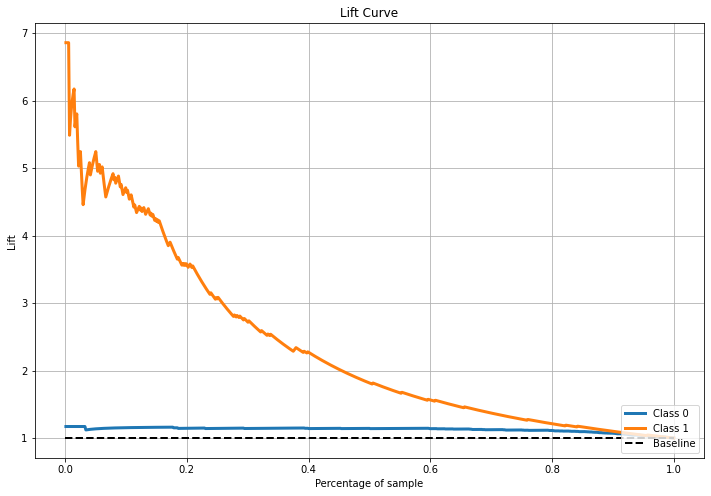

In [37]:
skplt.metrics.plot_lift_curve(y_test, automl_predProb)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

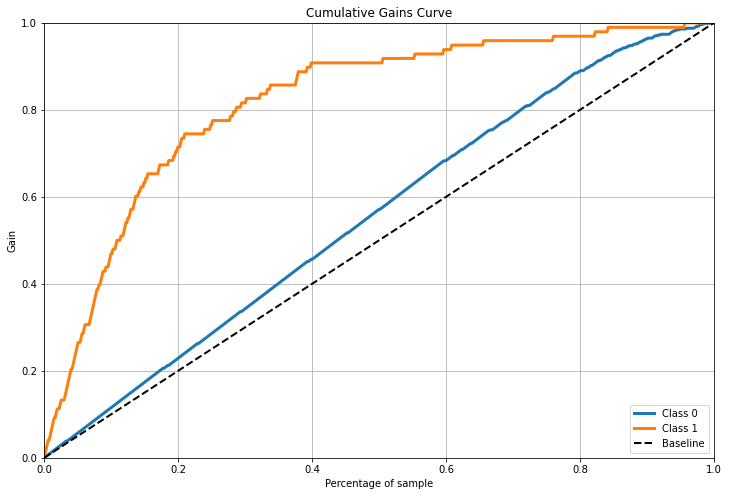

In [38]:
skplt.metrics.plot_cumulative_gain(y_test, automl_predProb)

array([[0.93, 0.07],
       [0.97, 0.03],
       [0.91, 0.09],
       ...,
       [0.7 , 0.3 ],
       [0.22, 0.78],
       [0.88, 0.12]])